In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from mpl_toolkits import mplot3d

from cca import ComplexityComponentsAnalysis
import cca.synth_data



In [7]:
def gen_noise_cov(N, d, variance):
    noise_spectrum = variance*np.exp(-np.arange(N)/(d/2))
    noise_V = scipy.stats.ortho_group.rvs(N)
    noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))
    return noise_cov

def cca_pca(N, T, cross_cov_mats, min_dim=1, max_dim=None, num_reps=1):
    opt = ComplexityComponentsAnalysis(T=T, init="random_ortho", device=None, use_scipy=True)
    opt.cross_covs = cross_cov_mats
    
    w, V = scipy.linalg.eigh(cross_cov_mats[0])
    w, V = w[::-1], V[:, ::-1]
    #pve = np.cumsum(w) / np.sum(w)
    
    if max_dim is None:
        max_dim = N
        
    dim_vals = np.arange(min_dim, max_dim+1)
    cca_pi_vals = np.zeros((len(dim_vals), num_reps))
    pca_pi_vals = np.zeros(len(dim_vals))
    V_set = []
    
    for dim_idx in range(len(dim_vals)):
        opt_dim = dim_vals[dim_idx]
        V_set_for_dim = []
        for rep_idx in range(num_reps):
            #if rep_idx % 10 == 0:
            print("rep =", rep_idx+1)
            opt.fit_projection(d=opt_dim)
            V_set_for_dim.append(opt.coef_)
            cca_pi = opt.score()
            cca_pi_vals[dim_idx, rep_idx] = cca_pi
        V_set.append(V_set_for_dim)
        opt.coef_ = V[:, :opt_dim]
        pca_pi = opt.score()
        pca_pi_vals[dim_idx] = pca_pi
        
        print(opt_dim, cca_pi, pca_pi)
        
    return dim_vals, cca_pi_vals, pca_pi_vals, V_set

def plot_cca_pca(dim_vals, cca_pi, pca_pi, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(dim_vals, cca_pi, linewidth=3, label="CCA", color="red")
    ax.plot(dim_vals, pca_pi, linewidth=3, label="PCA", color="black", linestyle="--")
    ax.set_ylabel("predictive information [bits]", fontsize=14)
    ax.set_xlabel("dimensionality", fontsize=14)
    ax.legend(fontsize=14, frameon=False)
    if title is not None:
        ax.set_title(title, fontsize=16)
        
def disp_cov(cov, title=None):
    s = np.max(np.abs(cov))
    plt.imshow(cov, vmin=-s, vmax=s, cmap="RdGy")
    plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)
        
def check_nested_subspaces(V_set):
    errs = np.zeros(len(V_set) - 1)
    for i in range(len(errs)):
        V = V_set[i][0]
        V_next = V_set[i + 1][0]
        P_next = np.dot(V_next, V_next.T)
        err = np.sqrt(np.sum((np.dot(P_next, V) - V)**2)/np.sum(V**2))
        errs[i] = err
    return errs
        
def dfs_util(A, visited, i):
    n = A.shape[0]
    visited[i] = 1
    nodes = [i]
    for j in range(n):
        if j != i and A[i, j] == 1:
            if visited[j] == 0:
                nodes += dfs_util(A, visited, j)
    return nodes

def connected_components(A):
    n = A.shape[0]
    visited = np.zeros(n)
    ccs = []
    for i in range(n):
        if visited[i] == 0:
            nodes = dfs_util(A, visited, i)
            ccs.append(sorted(nodes))
    return ccs

def subspace_adj_mat(bases, tol=1e-6):
    n = len(bases)
    A = np.zeros((n, n))
    for i in range(n):
        V_1 = bases[i]
        for j in range(i + 1, n):
            V_2 = bases[j]
            svs = scipy.linalg.svd(np.dot(V_1.T, V_2))[1]
            err = 1. - np.mean(svs)
            if err <= tol:
                A[i, j] = 1
    A = A + A.T
    return A
    
def subspace_hist(bases, vals, tol=1e-6):
    #return: count_vals, pi_vals
    
    A = subspace_adj_mat(bases, tol=tol)
    ccs = connected_components(A)
    
    num_ccs = len(ccs)
    counts = np.array([len(ccs[i]) for i in range(num_ccs)])
    avg_vals = np.array([np.mean(vals[ccs[i]]) for i in range(num_ccs)])
    
    idx = np.argsort(avg_vals)[::-1]
    counts, avg_vals = counts[idx], avg_vals[idx]
    
    return counts, avg_vals

def plot_cca_multiple_runs(V_set, pi_vals, title=None, tol=1e-6):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    counts, avg_pi_vals = subspace_hist(V_set, pi_vals, tol=tol)
    x_vals = np.arange(len(counts)) + 1
    rel_counts = counts/np.sum(counts)
    ax.bar(x_vals, rel_counts, zorder=0, label="relative frequency")
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x_vals)
    ax.set_xlabel("subspace index", fontsize=16)
    ax.set_ylabel("relative frequency", fontsize=16)
    ax.set_ylim([0, np.max(rel_counts)*1.2])
    
    ax2 = ax.twinx()
    ax2.set_ylabel("PI [bits]", fontsize=16)
    ax2.plot(x_vals, avg_pi_vals, c="black", zorder=1, marker=".", markersize=15, label="PI [bits]")
    ax2.set_ylim([0, np.max(avg_pi_vals)*1.2])
    
    ax.legend(fontsize=14, frameon=False, loc="upper left")
    ax2.legend(fontsize=14, frameon=False, loc="upper right")
    


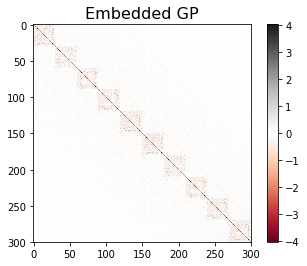

In [3]:
#Embedd a GP and add noise

N = 30
spatial_scale = 1
temporal_scale = 5
K = cca.synth_data.gen_gp_kernel("squared_exp", spatial_scale=spatial_scale, temporal_scale=temporal_scale)

noise_dim = 10
noise_var = 10
noise_cov = gen_noise_cov(N, noise_dim, noise_var)

T = 100
d = 10
T_pi = 5
num_to_concat = 1
X, _, _, _, cross_cov_mats = cca.synth_data.embed_gp(T, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)

cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)
disp_cov(cov, "Embedded GP")
#plt.savefig("figs/embedded_gp_cov.pdf", bbox_inches="tight")
plt.show()

In [4]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, num_reps=1)

rep = 1
1 3.2623941292395395 0.009547331767423273
rep = 1
2 6.436110666517971 0.021328382677771974
rep = 1
3 8.896404223879985 0.05871958697503784
rep = 1
4 11.122913326572819 0.09748520826169563
rep = 1
5 12.821218935253079 0.14082378967417034
rep = 1
6 14.338281766383908 0.2844999077351449
rep = 1
7 15.594248927390913 0.42740441618895303
rep = 1
8 16.49519751759982 0.6605919228742544
rep = 1
9 17.11826928263139 0.8700901383005578
rep = 1
10 17.52285776610252 1.2313886041643876
rep = 1
11 17.522857775001256 2.013337605700345
rep = 1


KeyboardInterrupt: 

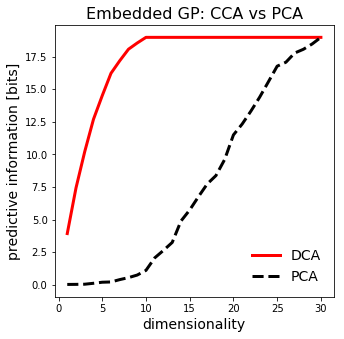

In [59]:
plot_cca_pca(dim_vals, cca_pi_vals, pca_pi_vals, title="Embedded GP: CCA vs PCA")
#plt.savefig("figs/embedded_gp_cca.pdf", bbox_inches="tight")
plt.show()

(200000, 10)


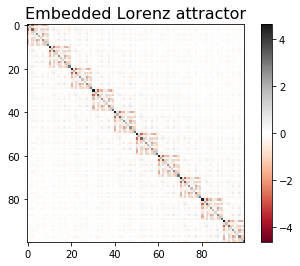

In [39]:
#Embedded Lorenz attractor

N = 10
T = 10000
integration_dt = 0.005
data_dt = 0.05

noise_dim = 3
noise_var = 10
noise_cov = gen_noise_cov(N, noise_dim, noise_var)

X = cca.synth_data.embed_lorenz_system(T, integration_dt, data_dt, N, noise_cov)
print(X.shape)

T_pi = 5
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_data(X, 2*T_pi)

cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)
disp_cov(cov, "Embedded Lorenz attractor")
#plt.savefig("figs/embedded_lorenz_cov.pdf", bbox_inches="tight")
plt.show()

In [45]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, min_dim=1, max_dim=3, num_reps=500)

rep = 1
rep = 2
rep = 3
rep = 4
rep = 5
rep = 6
rep = 7
rep = 8
rep = 9
rep = 10
rep = 11
rep = 12
rep = 13
rep = 14
rep = 15
rep = 16
rep = 17
rep = 18
rep = 19
rep = 20
rep = 21
rep = 22
rep = 23
rep = 24
rep = 25
rep = 26
rep = 27
rep = 28
rep = 29
rep = 30
rep = 31
rep = 32
rep = 33
rep = 34
rep = 35
rep = 36
rep = 37
rep = 38
rep = 39
rep = 40
rep = 41
rep = 42
rep = 43
rep = 44
rep = 45
rep = 46
rep = 47
rep = 48
rep = 49
rep = 50
rep = 51
rep = 52
rep = 53
rep = 54
rep = 55
rep = 56
rep = 57
rep = 58
rep = 59
rep = 60
rep = 61
rep = 62
rep = 63
rep = 64
rep = 65
rep = 66
rep = 67
rep = 68
rep = 69
rep = 70
rep = 71
rep = 72
rep = 73
rep = 74
rep = 75
rep = 76
rep = 77
rep = 78
rep = 79
rep = 80
rep = 81
rep = 82
rep = 83
rep = 84
rep = 85
rep = 86
rep = 87
rep = 88
rep = 89
rep = 90
rep = 91
rep = 92
rep = 93
rep = 94
rep = 95
rep = 96
rep = 97
rep = 98
rep = 99
rep = 100
rep = 101
rep = 102
rep = 103
rep = 104
rep = 105
rep = 106
rep = 107
rep = 108
rep = 109
rep = 110
rep = 11

rep = 338
rep = 339
rep = 340
rep = 341
rep = 342
rep = 343
rep = 344
rep = 345
rep = 346
rep = 347
rep = 348
rep = 349
rep = 350
rep = 351
rep = 352
rep = 353
rep = 354
rep = 355
rep = 356
rep = 357
rep = 358
rep = 359
rep = 360
rep = 361
rep = 362
rep = 363
rep = 364
rep = 365
rep = 366
rep = 367
rep = 368
rep = 369
rep = 370
rep = 371
rep = 372
rep = 373
rep = 374
rep = 375
rep = 376
rep = 377
rep = 378
rep = 379
rep = 380
rep = 381
rep = 382
rep = 383
rep = 384
rep = 385
rep = 386
rep = 387
rep = 388
rep = 389
rep = 390
rep = 391
rep = 392
rep = 393
rep = 394
rep = 395
rep = 396
rep = 397
rep = 398
rep = 399
rep = 400
rep = 401
rep = 402
rep = 403
rep = 404
rep = 405
rep = 406
rep = 407
rep = 408
rep = 409
rep = 410
rep = 411
rep = 412
rep = 413
rep = 414
rep = 415
rep = 416
rep = 417
rep = 418
rep = 419
rep = 420
rep = 421
rep = 422
rep = 423
rep = 424
rep = 425
rep = 426
rep = 427
rep = 428
rep = 429
rep = 430
rep = 431
rep = 432
rep = 433
rep = 434
rep = 435
rep = 436
rep = 437


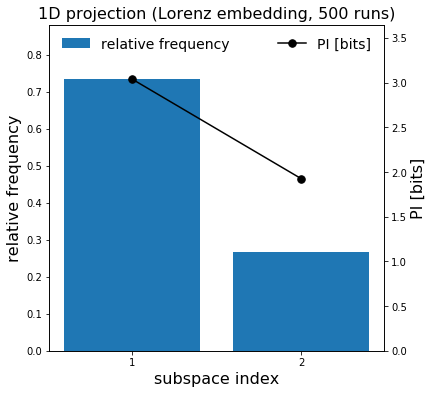

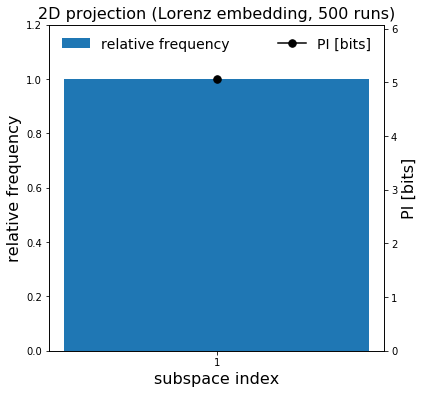

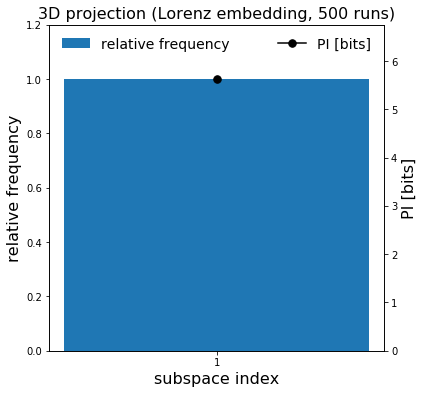

In [46]:
plot_cca_multiple_runs(V_set[0], cca_pi_vals[0, :], "1D projection (Lorenz embedding, 500 runs)", tol=1e-6)
#plt.savefig("local_minima_1D.pdf", bbox_inches="tight")
plt.show()

plot_cca_multiple_runs(V_set[1], cca_pi_vals[1, :], "2D projection (Lorenz embedding, 500 runs)", tol=1e-6)
#plt.savefig("local_minima_2D.pdf", bbox_inches="tight")
plt.show()

plot_cca_multiple_runs(V_set[2], cca_pi_vals[2, :], "3D projection (Lorenz embedding, 500 runs)", tol=1e-6)
#plt.savefig("local_minima_3D.pdf", bbox_inches="tight")
plt.show()


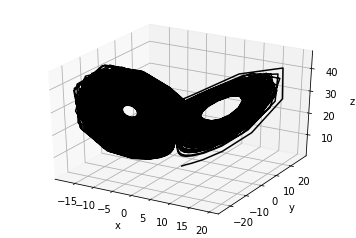

None


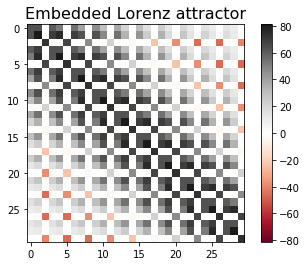

In [12]:
T = 10000
integration_dt = 0.005
data_dt = 0.05
X = cca.synth_data.gen_lorenz_system(T, integration_dt, data_dt)

ax = plt.axes(projection='3d')
ax.plot3D(X[:5000,0], X[:5000,1], X[:5000,2], 'black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

T_pi = 5
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_data(X, 2*T_pi)

cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)
disp_cov(cov, "Embedded Lorenz attractor")
plt.show()

-0.0010512570135071452

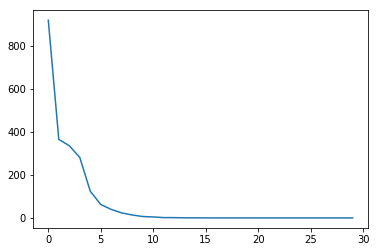

In [13]:
w, _ = scipy.linalg.eigh(cov)
plt.plot(w[::-1])

np.min(w)

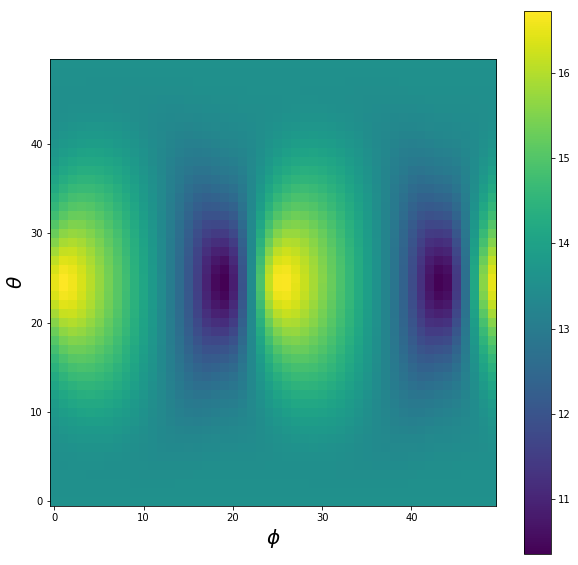

In [14]:
min_eig = np.min(scipy.linalg.eigh(cov)[0])
if min_eig <= 0:
    cross_cov_mats[0] = cross_cov_mats[0] - min_eig*np.eye(3) + 1e-6

N_theta = 50
N_phi = 50

theta = np.linspace(0, np.pi, N_theta)
phi = np.linspace(0, 2*np.pi, N_phi)

heatmap = np.zeros((N_theta, N_phi))

def pi_val(theta, phi):
    x = np.cos(phi)*np.sin(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(theta)
    v = np.array([x, y, z]).reshape((3, 1))
    pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
    return pi

for theta_idx in range(N_theta):
    for phi_idx in range(N_phi):
        pi = pi_val(theta[theta_idx], phi[phi_idx])
        heatmap[theta_idx, phi_idx] = pi

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(heatmap, origin="lower left")
ax.set_xlabel("$\phi$", fontsize=20)
ax.set_ylabel("$\\theta$", fontsize=20)

fig.colorbar(im, ax=ax)
plt.show()

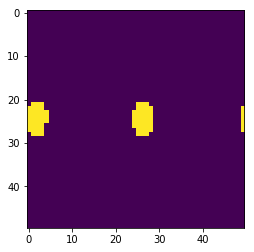

In [17]:

plt.imshow(heatmap > 16)

In [19]:
min_eig

-0.00016657750352933674

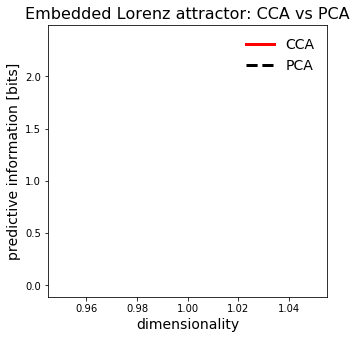

In [18]:
plot_cca_pca(dim_vals, cca_pi_vals.mean(axis=1), pca_pi_vals,  "Embedded Lorenz attractor: CCA vs PCA")
#plt.savefig("figs/embedded_lorenz_cca.pdf", bbox_inches="tight")
plt.show()

plot_cca_multiple_runs(V_set[0], cca_pi_vals[0, :], "1D projection (Lorenz embedding, 500 runs)", tol=1e-4)
#plt.savefig("local_minima.pdf", bbox_inches="tight")
plt.show()

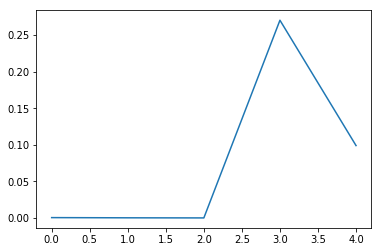

In [392]:
errs = check_nested_subspaces(V_set)
plt.plot(errs)

In [4]:
#Load RNN data

f = h5py.File("rnn_data.hdf5", "r")
X_full = f["data"]
T_full, N = X_full.shape
dt_full = f.attrs["dt"]

#Load a few hours of data (24 hours available)
num_hours = 10

#and grab a reduced set of neurons
N = 30

T = int(np.round( num_hours*60**2 / dt_full ))
dt = 0.100
skip = int(np.round( dt / dt_full ))
X = X_full[0:T:skip, :N]

T_pi = 5
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_data(X, 2*T_pi)
cov = cca.cov_util.calc_cov_from_cross_cov_mats(cross_cov_mats)

disp_cov(cov, "Chaotic RNN")
#plt.savefig("figs/rnn_cov.pdf", bbox_inches="tight")
plt.show()

OSError: Unable to open file (unable to open file: name = 'rnn_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [351]:
dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, T_pi, cross_cov_mats, min_dim=1, max_dim=5, num_reps=1)

1 2.161156887281543 1.5985613588938534
2 2.9315140190936853 2.327914526399957
3 3.9292253411451044 2.660552774895605
4 4.535373663753842 3.4356774289171472
5 5.145857621809781 4.0139304583218935


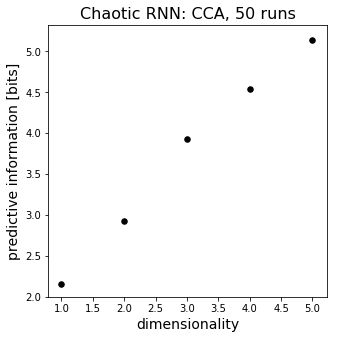

In [352]:
plot_cca_multiple_runs(dim_vals, V_set, cca_pi_vals, title="Chaotic RNN: CCA, 50 runs")
plt.show()

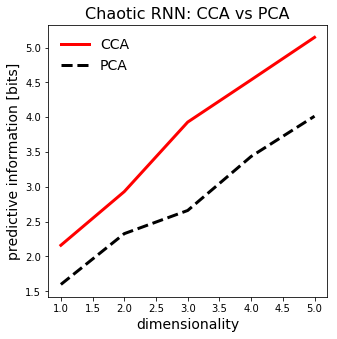

In [353]:
plot_cca_pca(dim_vals, cca_pi_vals.mean(axis=1), pca_pi_vals, title="Chaotic RNN: CCA vs PCA")
#plt.savefig("figs/rnn_cca.pdf", bbox_inches="tight")
plt.show()

In [343]:
dim_vals

array([1, 2, 3, 4, 5])